# Optimal control of intervention strategies for a Zika virus model

This notebook demonstrates how to use WhyNot for sequential decision making experiments in a model of [Zika virus transmission](https://whynot-docs.readthedocs-hosted.com/en/latest/simulators.html#zika-simulator). The simulator is based on [the following paper](https://www.sciencedirect.com/science/article/pii/S2211692316301084#b25):

- Momoh, Abdulfatai A., and Armin Fügenschuh. "Optimal control of intervention strategies and cost effectiveness analysis for a Zika virus model." Operations
Research for Health Care 18 (2018): 99-111.

We compare the efficacy of two policies at controlling the spread of Zika: a policy which does nothing and a constant treatment policy. Can you find something better?

In [44]:
%load_ext autoreload
%autoreload 2
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

import whynot as wn
import whynot.gym as gym

from scripts import utils

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting up the environment

WhyNot provides exactly the same interface as the OpenAI gym.

In [45]:
env = gym.make('Zika-v0')
env.seed(1);

## Construct baseline policies

We compare two trivial baselines. One policy that takes actions randomly and other that always opts
to perform a mixed treatment strategy of $u_1, \dots, u_4 = 0.5$ for each time step.

In [46]:
class NoTreatmentPolicy():
    def sample_action(self, obs):
        return np.zeros(env.action_space.shape)

class ConstantPolicy():
    def sample_action(self, obs):
        return 0.5 * np.ones(env.action_space.shape)
    
policies = {
    "No Treatment": NoTreatmentPolicy(),
    "Constant Treatment": ConstantPolicy(),
}

## Sampling trajectories

We sample trajectories according to a policy by sampling an action `ac`, taking the action via `env.step(ac)`,
observing the next state and reward, and then repeating.

In [47]:
def sample_trajectory(env, policy, max_episode_length):
    """Sample a single trajectory, acting according to the specified policy."""
    # initialize env for the beginning of a new rollout
    ob = env.reset()
    obs, acs, rewards, next_obs, terminals = [], [], [], [], []
    steps = 0
    while True:
        # Use the most recent observation to decide what to do
        obs.append(ob)
        ac = policy.sample_action(ob)
        acs.append(ac)

        # Take that action and record results
        ob, rew, done, _ = env.step(ac)

        # Record result of taking that action
        steps += 1
        next_obs.append(ob)
        rewards.append(rew)

        # End the rollout if the rollout ended
        # Note that the rollout can end due to done, or due to max_episode_length
        if done or steps > max_episode_length:
            rollout_done = 1
        else:
            rollout_done = 0
        terminals.append(rollout_done)
        if rollout_done:
            break

    return {"observation" : np.array(obs, dtype=np.float32),
            "reward" : np.array(rewards, dtype=np.float32),
            "action" : np.array(acs, dtype=np.float32),
            "next_observation": np.array(next_obs, dtype=np.float32),
            "terminal": np.array(terminals, dtype=np.float32)}

## Visualize sampled trajectories for each policy

In [48]:
def plot_sample_trajectory(policies):
    """Plot sample trajectories from policies."""
    obs_dim_names = wn.zika.State.variable_names()

    fig, axes = plt.subplots(5, 3, sharex=True, figsize=[18, 15])
    axes = axes.flatten()
    
    for name, policy in policies.items():
        trajectory = sample_trajectory(env, policy, 400)
        obs = trajectory["observation"]
        # Plot state evolution
        for i in range(len(obs_dim_names)):
            y = obs[:, i]
            axes[i].plot(y, label=name)
            axes[i].set_ylabel(obs_dim_names[i])
            ymin, ymax = axes[i].get_ylim()
            axes[i].set_ylim(np.minimum(ymin, y.min()), np.maximum(ymax, y.max()))
        
        # Plot actions
        
        actions = np.array(trajectory["action"])
        for idx, label in enumerate(["Bednet Use", "Condom Use", "Patient Treatment", "Indoor Spray Use"]):
            ax_idx = -5 + idx
            axes[ax_idx].plot(actions[:, idx], label=name)
            axes[ax_idx].set_ylabel(label)
            axes[ax_idx].set_ylim(0.0, 1.0)
        
        # Plot reward
        reward = trajectory["reward"]
        axes[-1].plot(reward, label=name)
        axes[-1].set_ylabel("reward")
        axes[-1].ticklabel_format(scilimits=(-2, 2))
        ymin, ymax = axes[-1].get_ylim()
        axes[-1].set_ylim(np.minimum(ymin, reward.min()), np.maximum(ymax, reward.max()))
    
        print(f"Total reward for {name}: {np.sum(reward):.2f}")
        
    for ax in axes:
        ax.legend()
        ax.set_xlabel("Year")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

No handles with labels found to put in legend.


Total reward for No Treatment: -11295708.00
Total reward for Constant Treatment: -2161319.00


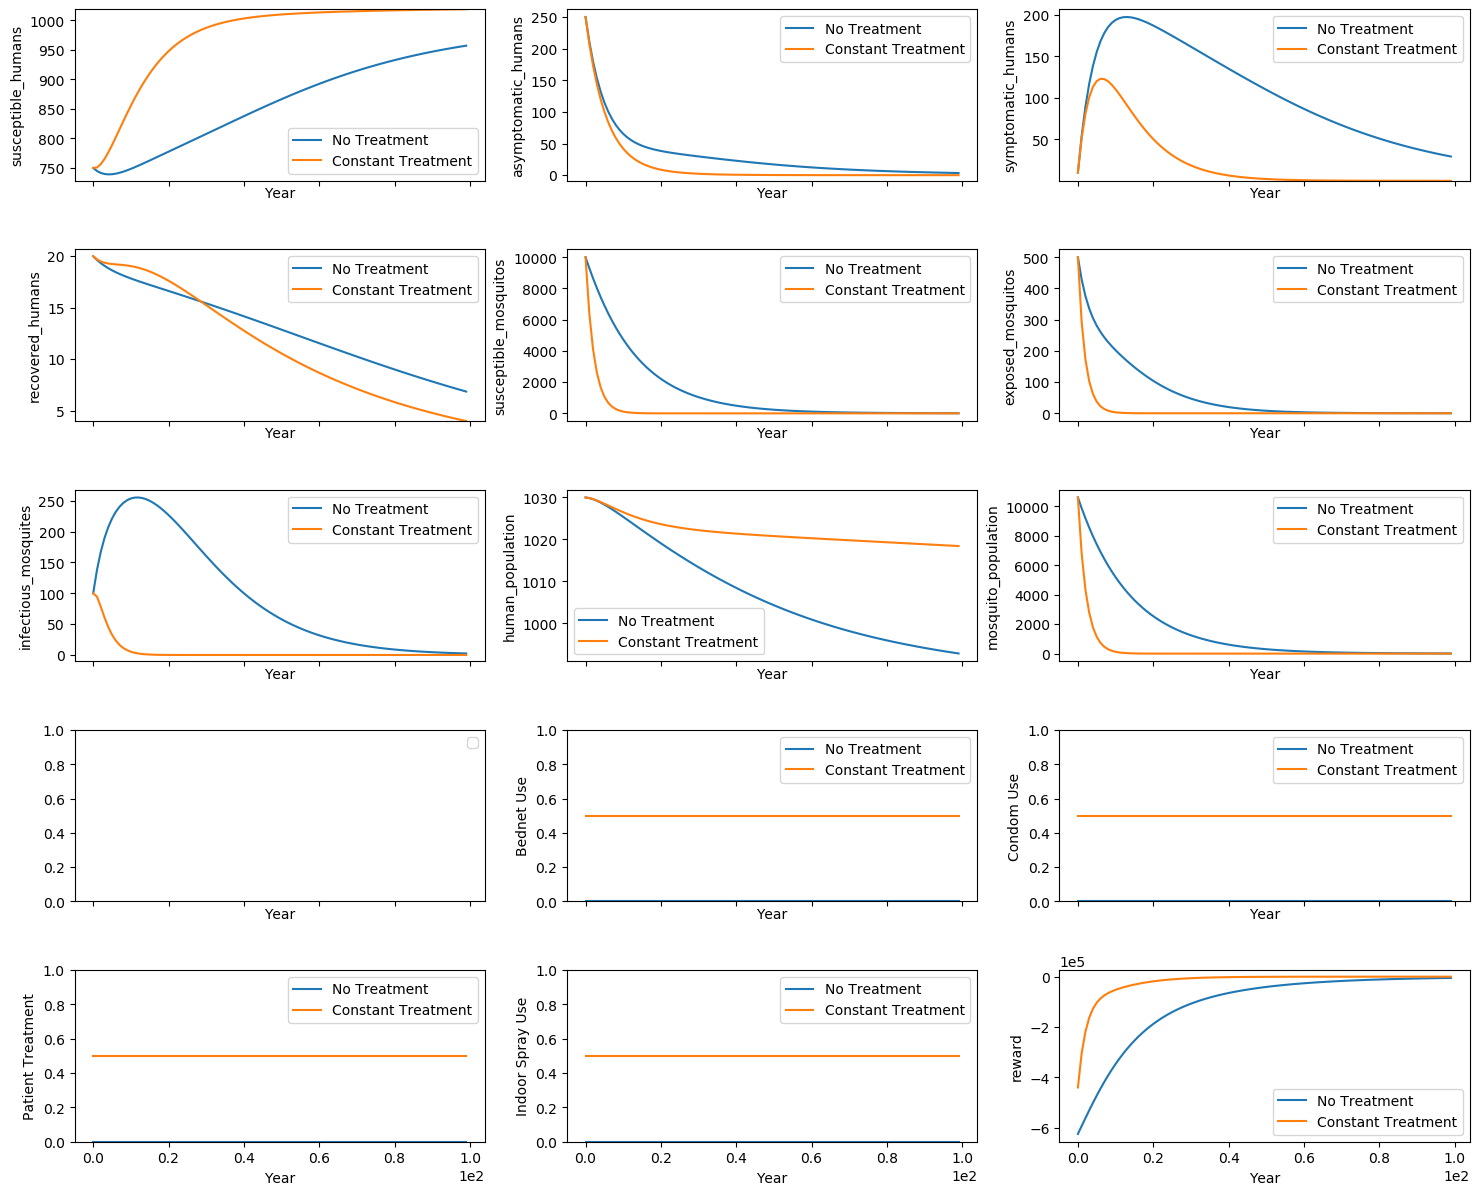

In [49]:
plot_sample_trajectory(policies)